In [11]:
import numpy as np
import functools
import time
import pygame
import random
import itertools
from invasionEngine.constants import Constants
import matplotlib.pyplot as plt

In [12]:
surface = pygame.Surface((200, 200))  # 创建测试用的 Surface 对象
class SurfaceCache():
    """
    由于pygame的Surface对象创建和销毁比较耗时，所以使用缓存来管理Surface对象
    尤其是加入摄像头系统后，每帧都会对surface进行旋转和缩放，所以更需要缓存
    其接受一个key = (original_image, zoom, angle)作为索引，返回一个缓存的surface
    为了避免空间无限的增加，缓存中存储的zoom和angle有粒度，并不是连续值。
    传入的zoom和angle会被转换为最接近的缓存值
    """
    def __init__(self,zoom_granularity_factor: float = 0.003,
                 angle_granularity_factor: float = 0.004,
                 zoom_range: tuple[float,float] = Constants.ZOOM_RANGE,
                 angle_range: tuple[float,float] = (0,360)):
        super().__init__()
        self.cache: dict[tuple[pygame.Surface, float, float], pygame.Surface] = {}
        self.zoom_granularity: float = zoom_granularity_factor * abs(zoom_range[1] - zoom_range[0])
        self.angle_granularity: float = angle_granularity_factor * abs(angle_range[1] - angle_range[0])

    #定义一个粒度调整函数，用于将传入的zoom和angle调整为最接近的缓存值
    def __granularity_adjust(self, zoom: float, angle: float) -> float:
        adjusted_zoom = round(zoom / self.zoom_granularity) * self.zoom_granularity
        adjusted_angle = round(angle / self.angle_granularity) * self.angle_granularity
        return (adjusted_zoom,adjusted_angle)
    
    @functools.lru_cache(maxsize = None)
    def  __surface_process(self, original_surface: pygame.Surface, zoom: float, angle: float) -> pygame.Surface:
        # 缩放和旋转图像
        processed_surface = pygame.transform.rotozoom(original_surface, angle, zoom)
        return processed_surface
    
    def lru_cache_get(self, original_surface: pygame.Surface, zoom: float, angle: float) -> pygame.Surface:
        adjusted_zoom, adjusted_angle = self.__granularity_adjust(zoom, angle)
        return self.__surface_process(original_surface, adjusted_zoom, adjusted_angle)
    
    def get(self, original_surface: pygame.Surface, zoom: float, angle: float) -> pygame.Surface:
        #需要在游戏对象的render方法中调用。备注
        # 对zoom和angle应用粒度调整
        adjusted_zoom, adjusted_angle = self.__granularity_adjust(zoom, angle)

        key = (original_surface, adjusted_zoom, adjusted_angle)

        if key not in self.cache:
            # 缩放和旋转图像
            # scaled_surface = pygame.transform.scale(original_surface, (int(original_surface.get_width() * adjusted_zoom), int(original_surface.get_height() * adjusted_zoom)))
            # rotated_surface = pygame.transform.rotate(scaled_surface, adjusted_angle)
            # self.cache[key] = rotated_surface

            processed_surface = pygame.transform.rotozoom(original_surface, adjusted_angle, adjusted_zoom)#这样处理比上面的方法质量更高耗时稍长
            self.cache[key] = processed_surface
            
        return self.cache[key]
        # return pygame.transform.rotozoom(original_surface, adjusted_angle, adjusted_zoom)
    def destroy(self):
        self.cache.clear()
        self.cache = {}
        self.__surface_process.cache_clear()
        #使用自省机制，将所有成员变量置空
        for name in dir(self):
            if not name.startswith('_'):
                setattr(self, name, None)
                

def dataset_gen(zoom_levels: np.ndarray[np.floating[any]],
                angles: np.ndarray[np.floating[any]],
                total_test_combinations: int = 2000,
                cache_hit_rate: float = 0.5,
                ) -> list[tuple[float, float]]:
    '''
    生成测试集
    '''
    # 生成所有可能的 zoom 和 angle 组合
    all_combinations = list(itertools.product(zoom_levels, angles))

    total_test_combinations = total_test_combinations  # 测试组合总数
    cache_hit_rate = cache_hit_rate  # 缓存命中率

    # 从所有组合中随机选取一定数量的唯一组合进行测试
    num_unique_combinations = int(total_test_combinations * (1 - cache_hit_rate) ) # 唯一组合数量
    unique_combinations = random.sample(all_combinations, num_unique_combinations)

    # 选择一部分唯一组合用于创建重复组合
    num_repeated_combinations = total_test_combinations - num_unique_combinations # 重复组合数量
    repeated_combinations = random.choices(unique_combinations, k=num_repeated_combinations)

    # 混合并随机化测试集
    test_combinations = unique_combinations + repeated_combinations
    random.shuffle(test_combinations)

    return test_combinations

# 测试函数
def test_lru_cache_get(test_combinations):
    global surface
    surface_cache = SurfaceCache()  # 创建 SurfaceCache 对象
    start_time = time.time()
    for zoom, angle in test_combinations:
        surface_cache.lru_cache_get(surface, zoom, angle)
    end_time = time.time()
    surface_cache.destroy()
    del surface_cache
    return (end_time - start_time) / len(test_combinations)

def test_get(test_combinations):
    global surface,surface_cache
    surface_cache = SurfaceCache()  # 创建 SurfaceCache 对象
    start_time = time.time()
    for zoom, angle in test_combinations:
        surface_cache.get(surface, zoom, angle)
    end_time = time.time()
    surface_cache.destroy()
    del surface_cache
    return (end_time - start_time) / len(test_combinations)

def run_test(num_tests: int, test_combinations: list[tuple[float, float]]):
    times_lru_cache_get = []
    times_get = []
    done_test_num = 0
    for _ in range(num_tests):
        # 测试 lru_cache_get 方法
        times_lru_cache_get.append(test_lru_cache_get(test_combinations))

        # 测试 get 方法
        times_get.append(test_get(test_combinations))

        done_test_num += 1
        progress = (done_test_num) / num_tests
        progress_bar = "[" + "=" * int(progress * 20) + " " * (20 - int(progress * 20)) + "]"
        print(f"\r进度: {progress_bar} {int(progress * 100)}%", end="")

    # 计算平均时间
    avg_time_lru_cache_get = sum(times_lru_cache_get) / num_tests
    avg_time_get = sum(times_get) / num_tests

    #输出谁更优
    if avg_time_lru_cache_get < avg_time_get:
        print(",lru_cache_get更优")
    else:
        print(",get更优")

    return avg_time_lru_cache_get, avg_time_get

In [13]:
# 初始化 Pygame
pygame.init()
zoom_levels = np.arange(0.2, 1.2, 0.01)  # 缩放级别
angles = np.arange(0, 361, 0.1)  # 旋转角度

In [18]:
total_test_combinations = 360  # 参与测试的（角度，放大倍数）组合总数
cache_hit_rate = np.arange(0.01, 0.1, 0.01)# 缓存命中率
num_tests = 50  # 每个缓存命中率参数对应的测试次数

进度: [====================] 100%,lru_cache_get更优
进度: [====================] 100%,get更优
进度: [====================] 100%,get更优
进度: [====================] 100%,get更优
进度: [====================] 100%,lru_cache_get更优
进度: [====================] 100%,lru_cache_get更优
进度: [====================] 100%,get更优
进度: [====================] 100%,get更优
进度: [====================] 100%,get更优


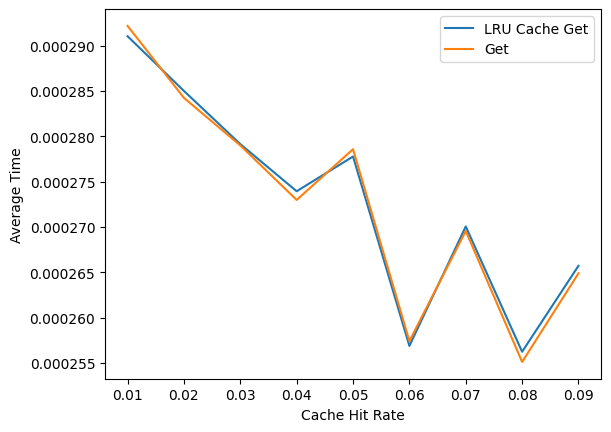

In [19]:
# 用于存储每个缓存命中率对应的平均运行时间
avg_time_lru_cache_get_list = []
avg_time_get_list = []

# 遍历缓存命中率序列，执行测试
for hit_rate in cache_hit_rate:
    test_combinations = dataset_gen(zoom_levels=zoom_levels, angles=angles, total_test_combinations=total_test_combinations, cache_hit_rate=float(hit_rate))
    avg_time_lru_cache_get, avg_time_get = run_test(num_tests, test_combinations)
    avg_time_lru_cache_get_list.append(avg_time_lru_cache_get)
    avg_time_get_list.append(avg_time_get)

# 绘制折线图
plt.plot(cache_hit_rate, avg_time_lru_cache_get_list, label='LRU Cache Get')
plt.plot(cache_hit_rate, avg_time_get_list, label='Get')
plt.xlabel('Cache Hit Rate')
plt.ylabel('Average Time')
plt.legend()
plt.show()